In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from pprint import pprint
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


# --- ŚRODOWISKO ---
class DartThrowEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.max_throw_range = 1.5
        self.max_steps = 1
        self.current_step = 0

        self.action_space = spaces.Box(
            low=np.array([-self.max_throw_range, -self.max_throw_range]),
            high=np.array([self.max_throw_range, self.max_throw_range]),
            dtype=np.float32
        )

        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)

        # proporcjonalne strefy
        self.radius_10 = self.max_throw_range * (1 / 5)  # 0.3
        self.radius_5 = self.max_throw_range * (2 / 5)   # 0.6
        self.radius_1 = self.max_throw_range * (4 / 5)   # 1.2

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        return np.array([0.0], dtype=np.float32), {}

    def step(self, action):
        self.current_step += 1
        done = True

        x, y = action
        dist = np.sqrt(x ** 2 + y ** 2)

        if dist < self.radius_10:
            reward = 10.0
        elif dist < self.radius_5:
            reward = 5.0
        elif dist < self.radius_1:
            reward = 1.0
        else:
            reward = -10.0

        obs = np.array([0.0], dtype=np.float32)
        return obs, reward, done, False, {}

In [2]:
# sieć przyjmuje wektor stanu, przetwarza go przez jedną ukrytą warstwę z 64 neuronami i aktywacją ReLU
# a następnie zwraca wektor wartości dla wszystkich możliwych akcji (output_dim)
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [3]:
def visualize_dartboard_cv2(env, throws=[], wait_time=1000):
    size = 500
    center = size // 2
    scale = center / env.max_throw_range
    img = np.ones((size, size, 3), dtype=np.uint8) * 255

    def draw_circle(radius, color):
        r = int(radius * scale)
        cv2.circle(img, (center, center), r, color, -1)

    draw_circle(env.radius_1, (200, 255, 200))   # jasnozielony (1 pkt)
    draw_circle(env.radius_5, (0, 255, 255))     # żółty (5 pkt)
    draw_circle(env.radius_10, (255, 0, 0))      # niebieski (10 pkt)

    for throw in throws:
        x, y = throw
        px = int(center + x * scale)
        py = int(center - y * scale)
        cv2.circle(img, (px, py), 4, (0, 0, 255), -1)

    cv2.imshow("Tarcza", img)
    cv2.waitKey(wait_time)
    cv2.destroyAllWindows()

In [4]:
def visualize_dartboard_matplotlib(env, throws=[]):
    fig, ax = plt.subplots(figsize=(6, 6))

    dartboard = [
        (1.2, 'lightgreen', '10 pkt', 1),
        (0.6, 'yellow', '5 pkt', 2),
        (0.3, 'blue', '1 pkt', 3),
    ]

    for radius, color, label, z in dartboard:
        circle = Circle((0, 0), radius, color=color, label=label, zorder=z)
        ax.add_patch(circle)

    # Dodaj rzuty
    throws = np.array(throws)
    if len(throws) > 0:
        ax.plot(throws[:, 0], throws[:, 1], 'ro', label='Rzuty', zorder=4)

    ax.set_xlim(-env.max_throw_range, env.max_throw_range)
    ax.set_ylim(-env.max_throw_range, env.max_throw_range)
    ax.set_aspect('equal')
    ax.set_title("Tarcza do rzutek")
    ax.legend()
    ax.grid(True)
    plt.show()


/Users/ukostuch/Documents/SEM6/INTELIGENCJA_OBLICZENIOWA/LAB4/sklearn-env/lib/python3.13/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/ukostuch/Documents/SEM6/INTELIGENCJA_OBLICZENIOWA/LAB4/sklearn-env/lib/python3.13/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Epizod 0, suma nagród: 56.0


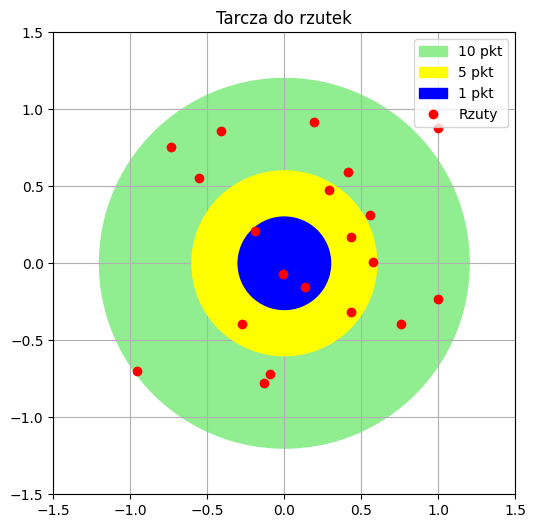

2025-05-15 18:20:42.417 Python[23245:1275664] +[IMKClient subclass]: chose IMKClient_Modern
2025-05-15 18:20:42.417 Python[23245:1275664] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Epizod 50, suma nagród: 44.0


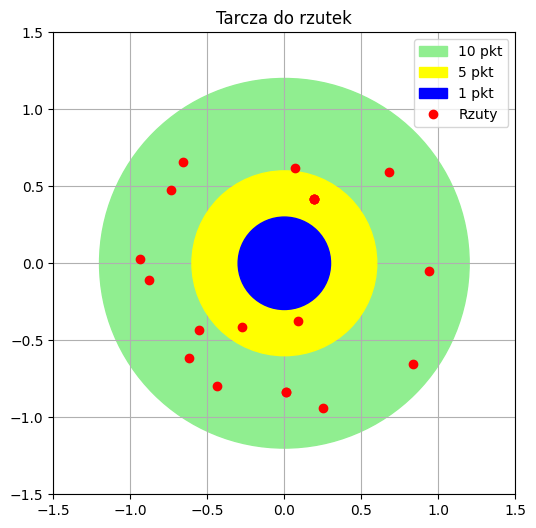

Epizod 100, suma nagród: 76.0


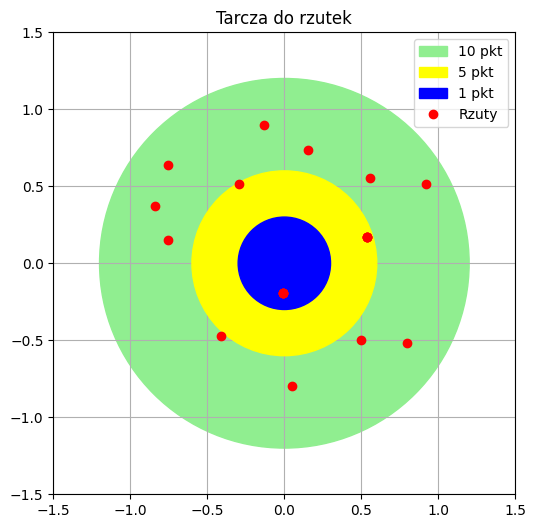

Epizod 150, suma nagród: 110.0


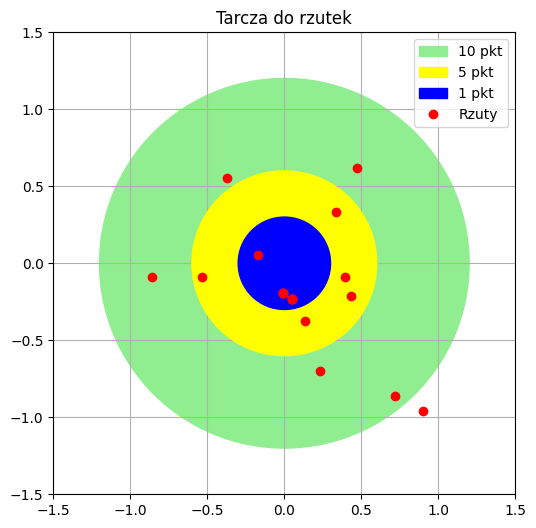

Epizod 200, suma nagród: 89.0


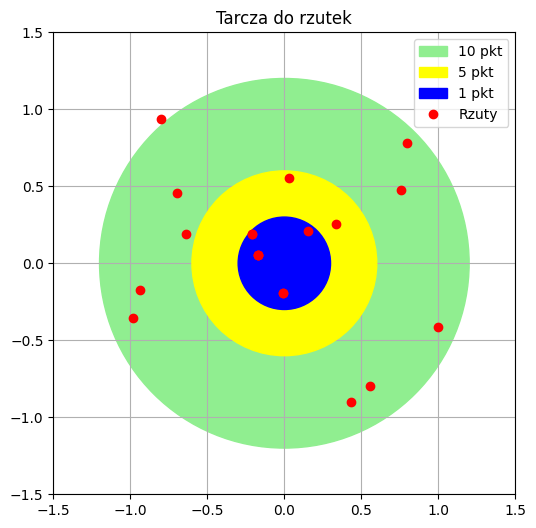

Epizod 250, suma nagród: 190.0


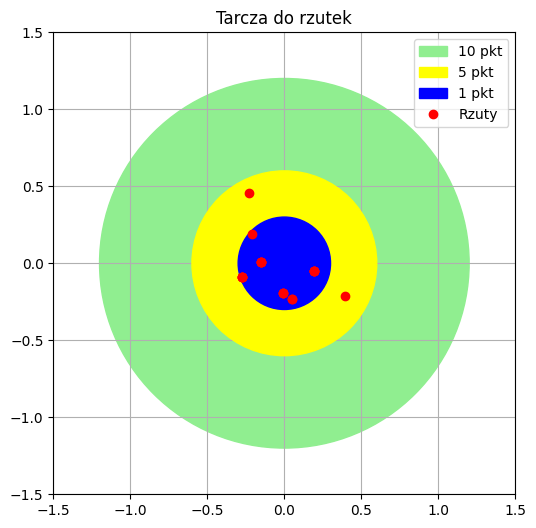

Epizod 300, suma nagród: 200.0


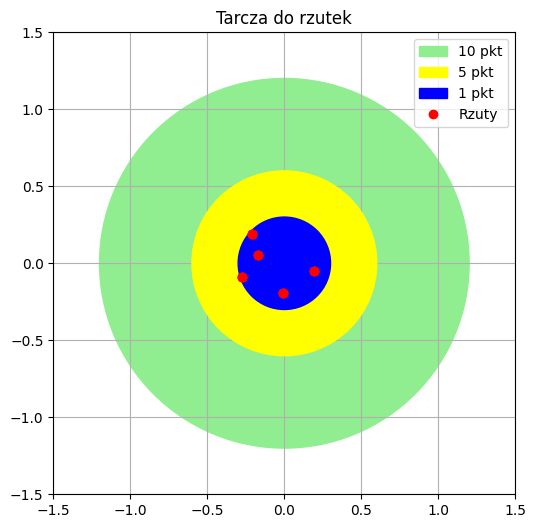

Epizod 350, suma nagród: 180.0


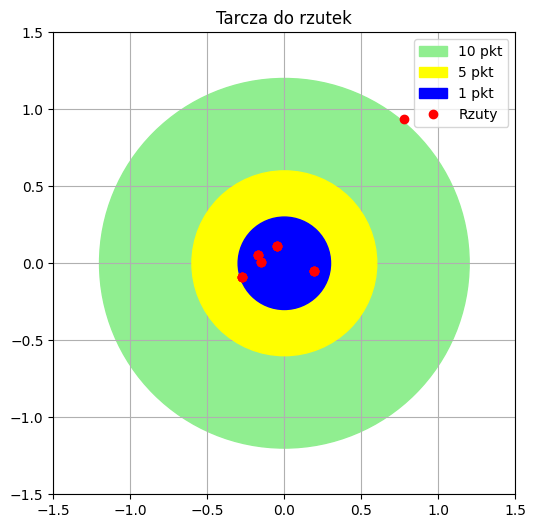

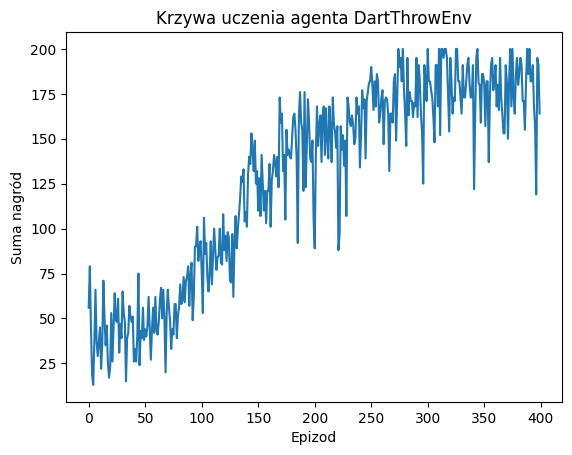

In [5]:

# --- TRENING ---
env = DartThrowEnv()

action_grid = np.array([[x, y] for x in np.linspace(-1, 1, 100)
                               for y in np.linspace(-1, 1, 100)])
action_size = len(action_grid)

learning_rate = 0.01
discount_factor = 0.9
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.99
num_episodes = 400
num_throws_per_episode = 20

state_size = env.observation_space.shape[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
q_network = QNetwork(state_size, action_size).to(device)  #agent uczy się przypisywać wartość  do każdego możliwego rzutu
optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

rewards_dqn = [] # lista do przechowywania sum nagród po każdym epizodzie

for episode in range(num_episodes):
    state, _ = env.reset()
    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
    total_reward = 0
    throws_in_episode = []
    throw_counts = defaultdict(int)

    for step in range(num_throws_per_episode):
        if np.random.rand() < epsilon:
            action_idx = np.random.randint(action_size)  #Losowy ruch (eksploracja)
            #na początku nauki epsilon=1.0, więc agent tylko losowo rzuca
        else:
            with torch.no_grad():
                q_values = q_network(state_tensor)
                action_idx = torch.argmax(q_values).item() # Najlepszy znany rzut
                # po pewnym czasie agent zaczyna ufać swoim przewidywaniom (q_network) i
                # wybiera taki punkt z action_grid, który ma najwyższy oczekiwany zysk

        attempts = 0
        while True:
            action = action_grid[action_idx]
            key = tuple(np.round(action, 3))
            if throw_counts[key] < 4:
                throw_counts[key] += 1
                break
            else:
                # Znajdź inną akcję (losową lub kolejną najlepszą)
                if np.random.rand() < epsilon:
                    action_idx = np.random.randint(action_size)
                else:
                    q_values[action_idx] = -float('inf')  # zablokuj tę akcję
                    action_idx = torch.argmax(q_values).item()

            attempts += 1
            if attempts > 100:  # zabezpieczenie na wypadek zablokowania wszystkich akcji
                break
        throws_in_episode.append(action)
        next_state, reward, done, _, _ = env.step(action)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(device)

        with torch.no_grad():
            next_q_values = q_network(next_state_tensor)
            #sieć neuronowa dostaje nowy stan next_state_tensor i przewiduje wartości Q dla wszystkich możliwych akcji w tym stanie
            #next_q_values to wektor który zawiera przewidywane zyski dla każdej możliwej akcji
            max_next_q = torch.max(next_q_values)
            target_q = reward + discount_factor * max_next_q
            # target_q to docelowa wartość Q - suma nagrody jaką dostaliśmy, plus wartość najlepszej możliwej akcji w kolejnym stanie — odpowiednio zdyskontowana

        predicted_q = q_network(state_tensor)[action_idx]
        # przepuszczamy aktualny stan gry przez sieć q_network żeby przewidzieć wartość (Q-value) wszystkich możliwych akcji i wybieramy akcje o indeksie action_idx
        loss = loss_fn(predicted_q, target_q)
        # strata to różnica między przewidywaną wartością Q a wartością docelową

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # aktualizujemy wagę sieci neuronowej na podstawie obliczonej straty.

        state_tensor = next_state_tensor
        total_reward += reward

    epsilon = max(epsilon_min, epsilon * epsilon_decay)  #aktualizacja epsilona
    # epsilon decay = 99% wiec  po każdym epizodzie  zmniejszamy wartość epsilon o 1%
    # epsilon maleje a agent coraz rzadziej wybiera losowe akcje
    # epsilon_min ustalamy żeby agent mial zawsze przynajmniej 5% szansy na eksplorację
    rewards_dqn.append(total_reward)

    if episode % 50 == 0:
        print(f"Epizod {episode}, suma nagród: {total_reward}")
        visualize_dartboard_matplotlib(env, throws=throws_in_episode)
    visualize_dartboard_cv2(env, throws=throws_in_episode, wait_time=1000)

env.close()

plt.plot(rewards_dqn, label="DQN (20 rzutów = 1 epizod)")
plt.xlabel('Epizod')
plt.ylabel('Suma nagród')
plt.title('Krzywa uczenia agenta DartThrowEnv')
plt.show()
